In [28]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

In [29]:
# NLTK kaynaklarını indir
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DangerClose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DangerClose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
# 1. Veri setlerini yükle
print("Veri setleri yükleniyor...")
questions_df = pd.read_csv('C:\\Users\\DangerClose\\Desktop\\Stack Overflow Q&A\\Questions.csv', encoding='iso-8859-1')
answers_df = pd.read_csv('C:\\Users\\DangerClose\\Desktop\\Stack Overflow Q&A\\Answers.csv', encoding='iso-8859-1')
tags_df = pd.read_csv('C:\\Users\\DangerClose\\Desktop\\Stack Overflow Q&A\\Tags.csv', encoding='iso-8859-1')

print(f"Questions veri seti: {questions_df.shape[0]} satır, {questions_df.shape[1]} sütun")
print(f"Answers veri seti: {answers_df.shape[0]} satır, {answers_df.shape[1]} sütun")
print(f"Tags veri seti: {tags_df.shape[0]} satır, {tags_df.shape[1]} sütun")

Veri setleri yükleniyor...
Questions veri seti: 1264216 satır, 7 sütun
Answers veri seti: 2014516 satır, 6 sütun
Tags veri seti: 3750994 satır, 2 sütun


In [32]:
# 2. Veri örnekleme (hızlı test için)
sample_size = 20000  # Örneklem boyutu
random_state = 42    # Tekrarlanabilirlik için

In [33]:
# İlk olarak sorular örneklemi oluştur
questions_sample = questions_df.sample(sample_size, random_state=random_state)
print(f"Sorular örneklem boyutu: {questions_sample.shape[0]}")

Sorular örneklem boyutu: 20000


In [34]:
# Bu sorulara ait cevapları bul
related_answers = answers_df[answers_df['ParentId'].isin(questions_sample['Id'])]
print(f"İlişkili cevap sayısı: {len(related_answers)}")

İlişkili cevap sayısı: 31650


In [35]:
# Bu sorulara ait etiketleri bul
related_tags = tags_df[tags_df['Id'].isin(questions_sample['Id'])]
print(f"İlişkili etiket sayısı: {len(related_tags)}")

İlişkili etiket sayısı: 59430


In [36]:
# 3. Basit ve sağlam temizleme fonksiyonları
def clean_html_text(text):
    """HTML etiketlerini kaldır ve metni temizle"""
    if not isinstance(text, str):
        return ""
    
    try:
        # HTML temizleme
        soup = BeautifulSoup(text, "html.parser")
        clean_text = soup.get_text()
        
        # Gereksiz boşlukları temizle
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()
        
        return clean_text
    except:
        return str(text)

In [37]:
def preprocess_text(text):
    """Metni tokenize et, stop words kaldır ve küçük harfe çevir"""
    if not isinstance(text, str) or text.strip() == "":
        return ""
    
    # Küçük harfe çevir
    text = text.lower()
    
    # Tokenize et
    try:
        tokens = word_tokenize(text)
    except:
        tokens = text.split()  # word_tokenize başarısız olursa basit split kullan
        
    # Stop words kaldır
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Alfanumerik olmayan karakterleri filtreleme
    tokens = [re.sub(r'[^a-zA-Z0-9]', '', word) for word in tokens]
    tokens = [word for word in tokens if word]  # Boş stringleri kaldır
    
    return " ".join(tokens)

In [38]:
# 4. Örnek bir kaç satır üzerinde kontrol
print("\nTemizleme işlemi test ediliyor...")
# Bir soru örneği
sample_question = questions_sample.iloc[0]
print(f"Soru ID: {sample_question['Id']}")
print(f"Orijinal başlık: {sample_question['Title']}")
print(f"Temizlenmiş başlık: {clean_html_text(sample_question['Title'])}")
print(f"İşlenmiş başlık: {preprocess_text(clean_html_text(sample_question['Title']))}")
print(f"Orijinal içerik (ilk 100 karakter): {sample_question['Body'][:100]}...")

# Bir cevap örneği
if len(related_answers) > 0:
    sample_answer = related_answers.iloc[0]
    print(f"\nCevap ID: {sample_answer['Id']}")
    print(f"İlişkili Soru ID: {sample_answer['ParentId']}")
    print(f"Orijinal içerik (ilk 100 karakter): {sample_answer['Body'][:100]}...")
    print(f"Temizlenmiş içerik: {clean_html_text(sample_answer['Body'])[:100]}...")
    print(f"İşlenmiş içerik: {preprocess_text(clean_html_text(sample_answer['Body']))[:100]}...")


Temizleme işlemi test ediliyor...
Soru ID: 17016800
Orijinal başlık: Handling the EditText send keyboard event for Android API16
Temizlenmiş başlık: Handling the EditText send keyboard event for Android API16
İşlenmiş başlık: handling edittext send keyboard event android api16
Orijinal içerik (ilk 100 karakter): <pre><code>import com.example.methanegaszonegeolocater.R;
import com.google.android.gms.maps.CameraU...

Cevap ID: 2382
İlişkili Soru ID: 2120
Orijinal içerik (ilk 100 karakter): <p>I have found the solution else where:</p>

<pre><code>SELECT SUBSTRING(master.dbo.fn_varbintohe...
Temizlenmiş içerik: I have found the solution else where: SELECT SUBSTRING(master.dbo.fn_varbintohexstr(HashBytes('MD5',...
İşlenmiş içerik: found solution else where select substringmasterdbofnvarbintohexstrhashbytesmd5 helloworld 32...


In [39]:
# 5. Sorular tablosunu temizle
print("\n5. Sorular tablosu temizleniyor...")
tqdm.pandas(desc="Başlıklar temizleniyor")
questions_sample['clean_title'] = questions_sample['Title'].progress_apply(clean_html_text)
questions_sample['processed_title'] = questions_sample['clean_title'].progress_apply(preprocess_text)

tqdm.pandas(desc="İçerikler temizleniyor")
questions_sample['clean_body'] = questions_sample['Body'].progress_apply(clean_html_text)
questions_sample['processed_body'] = questions_sample['clean_body'].progress_apply(preprocess_text)


5. Sorular tablosu temizleniyor...


Başlıklar temizleniyor:   0%|          | 0/20000 [00:00<?, ?it/s]C:\Users\DangerClose\AppData\Local\Temp\ipykernel_19780\2793261210.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
İçerikler temizleniyor: 100%|██████████| 20000/20000 [00:29<00:00, 675.37it/s]


In [41]:
# 6. Cevaplar tablosunu temizle
print("\n6. Cevaplar tablosu temizleniyor...")
# Açık bir kopya oluştur
related_answers = related_answers.copy()

tqdm.pandas(desc="Cevaplar temizleniyor")
related_answers['clean_body'] = related_answers['Body'].progress_apply(clean_html_text)
related_answers['processed_body'] = related_answers['clean_body'].progress_apply(preprocess_text)


6. Cevaplar tablosu temizleniyor...


Cevaplar temizleniyor:   0%|          | 0/31650 [00:00<?, ?it/s]

Cevaplar temizleniyor: 100%|██████████| 31650/31650 [00:44<00:00, 703.36it/s]


In [42]:
# 7. Cevapları soruya göre grupla
print("\n7. Cevaplar soruya göre gruplanıyor...")
answer_groups = related_answers.groupby('ParentId')['processed_body'].apply(' '.join).reset_index()
answer_groups.rename(columns={'ParentId': 'Id', 'processed_body': 'answers_text'}, inplace=True)



7. Cevaplar soruya göre gruplanıyor...


In [43]:
# 8. Etiketleri grupla
print("\n8. Etiketler soruya göre gruplanıyor...")
tag_groups = related_tags.groupby('Id')['Tag'].apply(list).reset_index()


8. Etiketler soruya göre gruplanıyor...


In [44]:
# 9. Tüm verileri birleştir
print("\n9. Tüm veriler birleştiriliyor...")
# Önce sorular ve etiketleri birleştir
questions_with_tags = questions_sample.merge(tag_groups, on='Id', how='left')
questions_with_tags['Tag'] = questions_with_tags['Tag'].fillna('').apply(lambda x: x if isinstance(x, list) else [])


9. Tüm veriler birleştiriliyor...


In [45]:
# Sonra cevapları ekle
full_dataset = questions_with_tags.merge(answer_groups, on='Id', how='left')
full_dataset['answers_text'] = full_dataset['answers_text'].fillna('')


In [46]:
# 10. Tam metin oluştur
print("\n10. Tam metinler oluşturuluyor...")
full_dataset['question_text'] = full_dataset['processed_title'] + ' ' + full_dataset['processed_body']
full_dataset['complete_text'] = full_dataset['question_text'] + ' ' + full_dataset['answers_text']


10. Tam metinler oluşturuluyor...


In [47]:
# Boş metin kontrolü
print(f"Soru metinlerinde boş olanlar: {(full_dataset['question_text'].str.strip() == '').sum()}")
print(f"Tam metinlerde boş olanlar: {(full_dataset['complete_text'].str.strip() == '').sum()}")

Soru metinlerinde boş olanlar: 0
Tam metinlerde boş olanlar: 0


In [48]:
# 11. En popüler etiketleri bul
print("\n11. En popüler etiketler bulunuyor...")
tag_counts = tags_df['Tag'].value_counts()
print(f"Toplam benzersiz etiket sayısı: {len(tag_counts)}")



11. En popüler etiketler bulunuyor...
Toplam benzersiz etiket sayısı: 37034


In [49]:
# En popüler N etiketi seç
top_n = 20
popular_tags = tag_counts.head(top_n).index.tolist()
print(f"En popüler {top_n} etiket: {popular_tags}")


En popüler 20 etiket: ['javascript', 'java', 'c#', 'php', 'android', 'jquery', 'python', 'html', 'c++', 'ios', 'mysql', 'css', 'sql', 'asp.net', 'objective-c', 'ruby-on-rails', '.net', 'c', 'iphone', 'angularjs']


In [50]:
# 12. One-hot encoding
print("\n12. Etiketler one-hot encoding yapılıyor...")
for tag in popular_tags:
    full_dataset[f'tag_{tag}'] = full_dataset['Tag'].apply(lambda x: 1 if tag in x else 0)


12. Etiketler one-hot encoding yapılıyor...


In [51]:
# 13. İşlenmiş veriyi kaydet
print("\n13. İşlenmiş veri kaydediliyor...")
output_dir = r"C:\\Users\\DangerClose\\Desktop\\Stack Overflow Q&A\\"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'model_ready_sample.csv')
full_dataset.to_csv(output_path, index=False, encoding='utf-8')
print(f"İşlenmiş veri kaydedildi: {output_path}")


13. İşlenmiş veri kaydediliyor...
İşlenmiş veri kaydedildi: C:\\Users\\DangerClose\\Desktop\\Stack Overflow Q&A\\model_ready_sample.csv



14. Etiket dağılımı görselleştiriliyor...


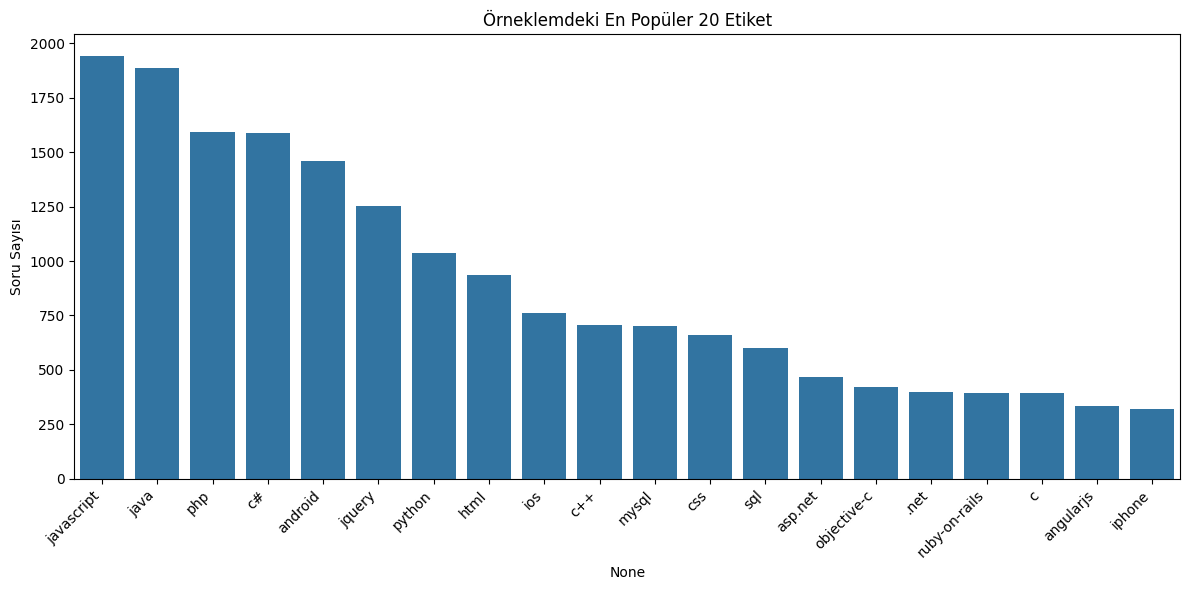

In [55]:
# 14. Etiket dağılımını görselleştir
print("\n14. Etiket dağılımı görselleştiriliyor...")
plt.figure(figsize=(12, 6))
tag_count_in_sample = full_dataset[['tag_' + tag for tag in popular_tags]].sum().sort_values(ascending=False)
sns.barplot(x=tag_count_in_sample.index.str.replace('tag_', ''), y=tag_count_in_sample.values)
plt.title(f'Örneklemdeki En Popüler {top_n} Etiket')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Soru Sayısı')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'popular_tags.png'))
plt.show()
plt.close()

In [53]:
# 15. Özet bilgiler
print("\n15. Özet bilgiler:")
print(f"Toplam temizlenmiş soru sayısı: {len(full_dataset)}")
print(f"Soru başına ortalama etiket sayısı: {full_dataset['Tag'].apply(len).mean():.2f}")
print(f"Soru başına ortalama kelime sayısı: {full_dataset['complete_text'].apply(lambda x: len(x.split())).mean():.2f}")
print(f"En popüler etiket: {popular_tags[0]} ({full_dataset[f'tag_{popular_tags[0]}'].sum()} soru)")


15. Özet bilgiler:
Toplam temizlenmiş soru sayısı: 20000
Soru başına ortalama etiket sayısı: 2.97
Soru başına ortalama kelime sayısı: 167.06
En popüler etiket: javascript (1944 soru)


In [54]:
# 16. Rastgele bir örnek göster
print("\n16. Rastgele bir örnek:")
random_sample = full_dataset.sample(1).iloc[0]
print(f"ID: {random_sample['Id']}")
print(f"Başlık: {random_sample['Title']}")
print(f"Temizlenmiş başlık: {random_sample['clean_title']}")
print(f"İşlenmiş başlık: {random_sample['processed_title']}")
print(f"Etiketler: {random_sample['Tag']}")
print(f"Tam metin (ilk 200 karakter): {random_sample['complete_text'][:200]}...")

print("\nTemizleme ve ön işleme tamamlandı! Model eğitimine geçebilirsiniz.")


16. Rastgele bir örnek:
ID: 26286860
Başlık: Trying to load another html page into a div using jQuery. I looked at other posts but mine still isn't working
Temizlenmiş başlık: Trying to load another html page into a div using jQuery. I looked at other posts but mine still isn't working
İşlenmiş başlık: trying load another html page div using jquery looked posts mine still working
Etiketler: ['javascript', 'jquery', 'html', 'load']
Tam metin (ilk 200 karakter): trying load another html page div using jquery looked posts mine still working please look edit link fiddle entire code httpjsfiddlenete77aqubx section jquery everything seems working fine trying get ...

Temizleme ve ön işleme tamamlandı! Model eğitimine geçebilirsiniz.
